# Franken goam analysis

The data for this example can be found [here](https://cloudstor.aarnet.edu.au/plus/apps/files/?dir=/MRI-Linac%20Experimental%20Data/FrankenGoam%5EMr&fileid=6991872825).

I'm first going to set up the variables to read in this data

In [1]:
from pathlib import Path
from mri_distortion_toolkit.MarkerAnalysis import MarkerVolume, MatchedMarkerVolumes
from mri_distortion_toolkit.utilities import enumerate_subfolders
from mri_distortion_toolkit import calculate_harmonics
import numpy as np
from mri_distortion_toolkit.utilities import get_dicom_data
from mri_distortion_toolkit.MarkerAnalysis import MatchedMarkerVolumes
from mri_distortion_toolkit.FieldCalculation import ConvertMatchedMarkersToBz
import pandas as pd

from mri_distortion_toolkit.Harmonics import SphericalHarmonicFit
import seaborn as sns
from matplotlib import pyplot as plt


dataloc = Path(r'/home/brendan/Downloads/FrankenGoam^Mr/20221107 MR Linac^Test')
scans = {'0': '01 localiser_gre',
         '1': '02 localiser_gre',
         '2': '03 localiser_gre',
         '3': '04 gre_trans_AP_330',
         '4': '05 gre_trans_PA_330',
         '5': '06 gre_sag_AP_330',
         '6': '07 gre_sag_PA_330',
         '7': '08 gre_cor_RL_330',
         '8': '09 gre_cor_LR_330',
         '9': '10 t1_tse_256_sag',
         '10': '11 t1_tse_256_sag_PA',
         '11': '12 t1_tse_256_tra_PA',
         '12': '13 t1_tse_256_sag_HF',
         '13': '14 t1_tse_256_sag_FH',  # for this one had to add gaussian_image_filter_sd=0.8
         '14': '15 t1_tse_256_cor_RL',
         '15': '16 t1_tse_256_cor_LR',
         '16': '17 localiser_gre',
         '17': '18 t1_tse_256_sag_HF_rot',
         '18': '19 t1_tse_256_sag_FH_rot',
         '19': '20 trufi_sag_128_torsocoil',
         '20': '21 trufi_sag_128_torsocoil',
         '21': '22 trufi_sag_128_torsocoil'}

## Marker extraction

Our first step is to extract the markers from each phantom.
> **Note that you can skip this step if you have already extracted and saved the marker positions as the next steps will read in these data files.**

In [2]:
# process TSE images
scans_to_segment = ['9', '11', '12', '13', '14']
gaussian_sd = [1,1,1,0.8,1,1]
for scan, sd in zip(scans_to_segment, gaussian_sd):
    volume = MarkerVolume(dataloc / scans[scan] / 'Original', n_markers_expected=618, iterative_segmentation=True,
                          gaussian_image_filter_sd=sd)
    print(f'for {scans[scan]}, {volume.MarkerCentroids.shape[0]} markers found')
    volume.export_to_slicer()
    volume.save_dicom_data()

Using thresold of  331.1
total segmentation time:  63.6 s
for 10 t1_tse_256_sag, 618 markers found
Using thresold of  315.5
total segmentation time:  63.1 s
for 12 t1_tse_256_tra_PA, 618 markers found
Using thresold of  254.4
total segmentation time:  58.9 s
for 13 t1_tse_256_sag_HF, 618 markers found
Using thresold of  254.4
total segmentation time:  50.8 s
for 14 t1_tse_256_sag_FH, 618 markers found
Using thresold of  241.9
total segmentation time:  53.0 s
for 15 t1_tse_256_cor_RL, 618 markers found


## Marker Matching

The next step is to match the markers from each of the distorted datasets to the ground truth data. Note that we have previously segmented the ground truth data, and simply import the pre-segmented data here.

In [12]:
gt_data_loc = Path(r'/home/brendan/Downloads/FrankenGoam^Mr/CT/slicer_centroids.mrk.json')
#align ground truth
gt_vol = MarkerVolume(gt_data_loc)
gt_vol.rotate_markers(yaxis_angle=180)
gt_vol.translate_markers(y_shift=-54)

tra_forward_vol = MarkerVolume(dataloc / scans['9'] / 'Original' / 'slicer_centroids.mrk.json')
tra_back_vol = MarkerVolume(dataloc / scans['11'] / 'Original' / 'slicer_centroids.mrk.json')
tra_match = MatchedMarkerVolumes(gt_vol, tra_forward_vol, reverse_gradient_data=tra_back_vol, n_refernce_markers=9)
tra_match.MatchedCentroids.to_csv('_data/tra_markers.csv')

sag_forward_vol = MarkerVolume(dataloc / scans['12'] / 'Original' / 'slicer_centroids.mrk.json')
sag_back_vol = MarkerVolume(dataloc / scans['13'] / 'Original' / 'slicer_centroids.mrk.json')
sag_match = MatchedMarkerVolumes(gt_vol, sag_forward_vol, reverse_gradient_data=sag_back_vol, n_refernce_markers=9)
sag_match.MatchedCentroids.to_csv('_data/sag_markers.csv')

cor_forward_vol = MarkerVolume(dataloc / scans['14'] / 'Original' / 'slicer_centroids.mrk.json')
cor_back_vol = MarkerVolume(dataloc / scans['15'] / 'Original' / 'slicer_centroids.mrk.json')
cor_match = MatchedMarkerVolumes(gt_vol, cor_forward_vol, reverse_gradient_data=cor_back_vol, n_refernce_markers=9)
cor_match.MatchedCentroids.to_csv('_data/cor_markers.csv')

[MarkerAnalysis.py: line 128  WARNING] MR data file dicom_data.json not found at /home/brendan/Downloads/FrankenGoam^Mr/CT. Continuing


aligning ground truth centroids by 
x    0.933333
y   -0.882222
z   -3.753333
dtype: float64
rotating ground truth centroids by 
[[ 0.99956145 -0.02737767 -0.0112856 ]
 [ 0.02757548  0.9994619   0.01776225]
 [ 0.01079323 -0.01806567  0.99977854]]
aligning ground truth centroids by 
x    0.824444
y   -0.777778
z   -3.697778
dtype: float64
rotating ground truth centroids by 
[[ 0.99948359 -0.0314802  -0.00644519]
 [ 0.03159597  0.99932529  0.01872583]
 [ 0.00585135 -0.0189198   0.99980388]]
aligning ground truth centroids by 
x    0.845556
y   -0.836667
z   -3.712222
dtype: float64
rotating ground truth centroids by 
[[ 0.99961028 -0.02775001 -0.00303719]
 [ 0.02779602  0.99948023  0.01632953]
 [ 0.00258247 -0.01640759  0.99986205]]


## Field calculation

Next step is to calculate the encoding fields from the distorted marker positions. Note that we obtain three field estimates; one from each forward/reverse marker set. Each field calculation includes an estimate of the gradient fields and the B0 field.

In [13]:
data_csv_loc = Path('_data').resolve()
# load the matched volume calculated in the previous step.
matched_volume = pd.read_csv(data_csv_loc / 'tra_markers.csv', index_col=0).squeeze("columns")
dicom_data = dataloc / scans['9'] / 'Original' / 'dicom_data.json'  # previously saved from a MarkerVolume
Bz_field = ConvertMatchedMarkersToBz(matched_volume, dicom_data)
Bz_field.MagneticFields.to_csv(data_csv_loc / 'tra_Bfields.csv')

matched_volume = pd.read_csv(data_csv_loc / 'sag_markers.csv', index_col=0).squeeze("columns")
dicom_data = dataloc / scans['12'] / 'Original' / 'dicom_data.json'  # previously saved from a MarkerVolume
Bz_field = ConvertMatchedMarkersToBz(matched_volume, dicom_data)
Bz_field.MagneticFields.to_csv(data_csv_loc / 'sag_Bfields.csv')

matched_volume = pd.read_csv(data_csv_loc / 'cor_markers.csv', index_col=0).squeeze("columns")
dicom_data = dataloc / scans['14'] / 'Original' / 'dicom_data.json'  # previously saved from a MarkerVolume
Bz_field = ConvertMatchedMarkersToBz(matched_volume, dicom_data)
Bz_field.MagneticFields.to_csv(data_csv_loc / 'cor_Bfields.csv')

## Harmonic calculation and averaging

We are now able to calculate the harmonics from each field data set.
Note that for each forward/reverse data set, we obtain:

- a good estimate of B0 (from the marker offsets in the frequency encode direction)
- A good estimate of the gradient in the **phase** and **frequency** direction.

The fields in the **slice encode** direction are not reliable, as in this direction we are not able to seperate out B0 and gradient effects. Therefore, we will simply discard these fields. The below table sums up which fields are involved in each direction:

| Scan orientation | Slice direction | Phase direction | Frequency direction |
| ---------------- | --------------- | --------------- | ------------------- |
| Transverse       | z               | **y**           | **x**               |
| Coronal          | y               | **x**           | **z**               |
| Sagital          | x               | **z**           | **y**               |

For each gradient, we obtain two estimates that we trust. We will simply take the average of these two estimates, and use this as our 'best guess'.

### Calculate all harmonics and save as csv:

In [18]:
# Transverse data
# ===================================================================================================================
FieldData = pd.read_csv(data_csv_loc / 'tra_Bfields.csv', index_col=0).squeeze("columns")
dicom_data_loc = Path(dataloc / scans['9'] / 'Original' / 'dicom_data.json')  # previosly saved from a MarkerVolume
dicom_data = get_dicom_data(dicom_data_loc)
gradient_strength = np.array(dicom_data['gradient_strength'])
normalisation_factor = [1 / gradient_strength[0], 1 / gradient_strength[1], 1 / gradient_strength[2],
                        1]  # this normalised gradient harmonics to 1mT/m
G_x_Harmonics, G_y_Harmonics, G_z_Harmonics, B0_Harmonics = calculate_harmonics(FieldData,
                                                                                n_order=5,
                                                                                scale=normalisation_factor)
# save for downstream analysis:
G_x_Harmonics.harmonics.to_csv(data_csv_loc / 'G_x_Harmonics_tra.csv')
G_y_Harmonics.harmonics.to_csv(data_csv_loc / 'G_y_Harmonics_tra.csv')
G_z_Harmonics.harmonics.to_csv(data_csv_loc / 'G_z_Harmonics_tra.csv')
if B0_Harmonics:  # None evaluates as False
    B0_Harmonics.harmonics.to_csv(data_csv_loc / 'B0_Harmonics_tra.csv')
# ======================================================================================================================

# Sagital data
# ===================================================================================================================
FieldData = pd.read_csv(data_csv_loc / 'sag_Bfields.csv', index_col=0).squeeze("columns")
dicom_data_loc = Path(dataloc / scans['12'] / 'Original' / 'dicom_data.json')  # previosly saved from a MarkerVolume
dicom_data = get_dicom_data(dicom_data_loc)
gradient_strength = np.array(dicom_data['gradient_strength'])
normalisation_factor = [1 / gradient_strength[0], 1 / gradient_strength[1], 1 / gradient_strength[2],
                        1]  # this normalised gradient harmonics to 1mT/m
G_x_Harmonics, G_y_Harmonics, G_z_Harmonics, B0_Harmonics = calculate_harmonics(FieldData,
                                                                                n_order=5,
                                                                                scale=normalisation_factor)

# save for downstream analysis:
G_x_Harmonics.harmonics.to_csv(data_csv_loc / 'G_x_Harmonics_sag.csv')
G_y_Harmonics.harmonics.to_csv(data_csv_loc / 'G_y_Harmonics_sag.csv')
G_z_Harmonics.harmonics.to_csv(data_csv_loc / 'G_z_Harmonics_sag.csv')
if B0_Harmonics:  # None evaluates as False
    B0_Harmonics.harmonics.to_csv(data_csv_loc / 'B0_Harmonics_sag.csv')
# ======================================================================================================================

# C data
# ===================================================================================================================
FieldData = pd.read_csv(data_csv_loc / 'cor_Bfields.csv', index_col=0).squeeze("columns")
dicom_data_loc = Path(dataloc / scans['14'] / 'Original' / 'dicom_data.json')  # previosly saved from a MarkerVolume
dicom_data = get_dicom_data(dicom_data_loc)
gradient_strength = np.array(dicom_data['gradient_strength'])
normalisation_factor = [1 / gradient_strength[0], 1 / gradient_strength[1], 1 / gradient_strength[2],
                        1]  # this normalised gradient harmonics to 1mT/m
G_x_Harmonics, G_y_Harmonics, G_z_Harmonics, B0_Harmonics = calculate_harmonics(FieldData,
                                                                                n_order=5,
                                                                                scale=normalisation_factor)

# save for downstream analysis:
G_x_Harmonics.harmonics.to_csv(data_csv_loc / 'G_x_Harmonics_cor.csv')
G_y_Harmonics.harmonics.to_csv(data_csv_loc / 'G_y_Harmonics_cor.csv')
G_z_Harmonics.harmonics.to_csv(data_csv_loc / 'G_z_Harmonics_cor.csv')
if B0_Harmonics:  # None evaluates as False
    B0_Harmonics.harmonics.to_csv(data_csv_loc / 'B0_Harmonics_cor.csv')



Initial pk-pk:        9.889e+02 μT
Reconstructed pk-pk:  9.884e+02 μT
Residual pk-pk:       3.581e+00 μT ( 0.4%)
Initial pk-pk:        9.885e+02 μT
Reconstructed pk-pk:  9.889e+02 μT
Residual pk-pk:       2.371e+00 μT ( 0.2%)


[Harmonics.py: line 205  WARNING] residual_pk_pk is greater than 2 %. This may indicate that the order is not high enough,or that the data is non physical (but it heavily depends on your use case!


Initial pk-pk:        3.319e+02 μT
Reconstructed pk-pk:  3.338e+02 μT
Residual pk-pk:       5.242e+00 μT ( 1.6%)
Initial pk-pk:        2.444e+01 μT
Reconstructed pk-pk:  2.275e+01 μT
Residual pk-pk:       1.924e+01 μT ( 78.7%)
Initial pk-pk:        2.799e+02 μT
Reconstructed pk-pk:  2.790e+02 μT
Residual pk-pk:       4.997e+00 μT ( 1.8%)
Initial pk-pk:        9.357e+02 μT
Reconstructed pk-pk:  9.364e+02 μT
Residual pk-pk:       3.189e+00 μT ( 0.3%)


[Harmonics.py: line 205  WARNING] residual_pk_pk is greater than 2 %. This may indicate that the order is not high enough,or that the data is non physical (but it heavily depends on your use case!


Initial pk-pk:        1.114e+03 μT
Reconstructed pk-pk:  1.113e+03 μT
Residual pk-pk:       1.339e+01 μT ( 1.2%)
Initial pk-pk:        2.484e+01 μT
Reconstructed pk-pk:  2.507e+01 μT
Residual pk-pk:       1.845e+01 μT ( 74.3%)
Initial pk-pk:        9.369e+02 μT
Reconstructed pk-pk:  9.365e+02 μT
Residual pk-pk:       3.489e+00 μT ( 0.4%)
Initial pk-pk:        2.786e+02 μT
Reconstructed pk-pk:  2.776e+02 μT
Residual pk-pk:       4.486e+00 μT ( 1.6%)


[Harmonics.py: line 205  WARNING] residual_pk_pk is greater than 2 %. This may indicate that the order is not high enough,or that the data is non physical (but it heavily depends on your use case!


Initial pk-pk:        1.111e+03 μT
Reconstructed pk-pk:  1.111e+03 μT
Residual pk-pk:       1.303e+01 μT ( 1.2%)
Initial pk-pk:        2.773e+01 μT
Reconstructed pk-pk:  2.846e+01 μT
Residual pk-pk:       1.904e+01 μT ( 68.7%)


### take the average of the different harmonics:

In [19]:
G_x1 = pd.read_csv(data_csv_loc / 'G_x_Harmonics_tra.csv', index_col=0).squeeze("columns")
G_x2 = pd.read_csv(data_csv_loc / 'G_x_Harmonics_cor.csv', index_col=0).squeeze("columns")
G_x = (G_x1 + G_x2) / 2
G_x.to_csv('_data/Gx.csv')

# Gy_Harmonics
G_y1 = pd.read_csv(data_csv_loc / 'G_y_Harmonics_tra.csv', index_col=0).squeeze("columns")
G_y2 = pd.read_csv(data_csv_loc / 'G_y_Harmonics_sag.csv', index_col=0).squeeze("columns")
G_y = (G_y1 + G_y2) / 2
G_y.to_csv('_data/Gy.csv')

# Gz_Harmonics
G_z1 = pd.read_csv(data_csv_loc / 'G_z_Harmonics_sag.csv', index_col=0).squeeze("columns")
G_z2 = pd.read_csv(data_csv_loc / 'G_z_Harmonics_cor.csv', index_col=0).squeeze("columns")
G_z = (G_z1 + G_z2) / 2
G_z.to_csv('_data/Gz.csv')


# B0
B01 = pd.read_csv(data_csv_loc / 'B0_Harmonics_sag.csv', index_col=0).squeeze("columns")
B02 = pd.read_csv(data_csv_loc / 'B0_Harmonics_cor.csv', index_col=0).squeeze("columns")
B03 = pd.read_csv(data_csv_loc / 'B0_Harmonics_tra.csv', index_col=0).squeeze("columns")
G_x = (B01 + B02 + B03) / 3
B01.to_csv('_data/B0.csv')
# input_data = pd.DataFrame({'x': [0, 0, 0], 'y': [0, 0, 0], 'z': [0, 0, 0], 'Bz': [0, 1, 2]})


## Test image correction

Ok. So now we have the average harmonics, we can test our ability to correct images.
We took some images with the phantom rotated 90 degrees. This will serve as an independant dataset.

Note that we have a lot of harmonics available now. You can change the below call and test out the performance of different harmonics.

In [20]:
from mri_distortion_toolkit.DistortionCorrection import ImageDomainDistortionCorrector
from mri_distortion_toolkit.utilities import plot_distortion_xyz_hist


distorted_data_loc = dataloc / scans['17'] / 'Original'  # this is a 'rotated' acquisition
dicom_data = get_dicom_data(distorted_data_loc / 'dicom_data.json')
GDC = ImageDomainDistortionCorrector(ImageDirectory=distorted_data_loc.resolve(),
                                gradient_harmonics=[Path('_data/Gx.csv').resolve(),
                                                    Path('_data/Gy.csv').resolve(),
                                                    Path('_data/Gz.csv').resolve()],
                                B0_harmonics=Path('_data/B0.csv').resolve(),
                                dicom_data=dicom_data,
                                ImExtension='dcm',
                                correct_through_plane=True,
                                correct_B0=True,
                                B0_direction='back')

GDC.correct_all_images()
GDC.save_all_images()  # saves as png so you can quickly inspect results
GDC.save_all_images_as_dicom()  # saves as dicom which can be read into analysis packages.

 |----------------------------------------------------------------------------------------------------| 0.0% 
 |███-------------------------------------------------------------------------------------------------| 3.1% 
 |██████----------------------------------------------------------------------------------------------| 6.1% 
 |█████████-------------------------------------------------------------------------------------------| 9.2% 
 |████████████----------------------------------------------------------------------------------------| 12.3% 
 |███████████████-------------------------------------------------------------------------------------| 15.3% 
 |██████████████████----------------------------------------------------------------------------------| 18.4% 
 |█████████████████████-------------------------------------------------------------------------------| 21.5% 
 |████████████████████████----------------------------------------------------------------------------| 24.5% 
 |███

[DistortionCorrection.py: line 233] 219755 negative pixels detected; setting these to zero and continuing


images export to png successful in 24.60451312409714 s
saving all data as dcm...
images exported to dicom in  0.3s


## Assess distortion correction

[MarkerAnalysis.py: line 128  WARNING] MR data file dicom_data.json not found at /home/brendan/Downloads/FrankenGoam^Mr/CT. Continuing


total segmentation time:  5.0 s
aligning ground truth centroids by 
x   -16.423341
y   -54.824885
z     1.251735
dtype: float64
rotating ground truth centroids by 
[[ 0.99984375 -0.00749027 -0.01601168]
 [ 0.00765598  0.99991751  0.01031325]
 [ 0.01593311 -0.01043423  0.99981861]]
mean distortion:  2.7 mm, std:  1.3 mm, Max:  7.2 mm
x_mean:  1.2 mm +-  1.0 mm. max  6.9 mm
y_mean:  1.9 mm +-  1.3 mm. max  6.1 mm
z_mean:  1.0 mm +-  0.7 mm. max  3.6 mm


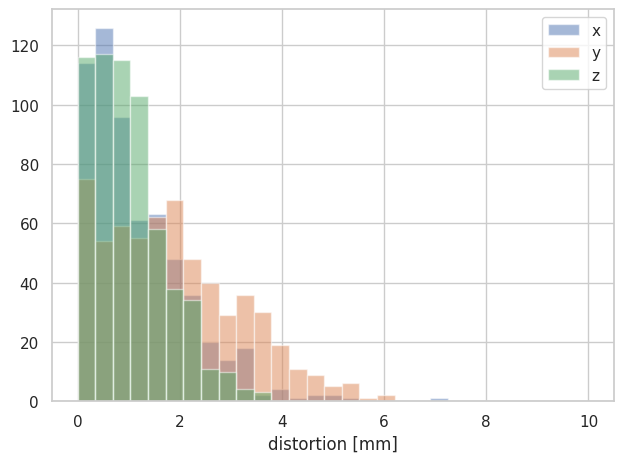

In [9]:
# Assess correction:
gt_data_loc = Path(r'/home/brendan/Downloads/FrankenGoam^Mr/CT/slicer_centroids.mrk.json')
# align ground truth:
gt_volume.rotate_markers(yaxis_angle=90)
gt_volume.rotate_markers(zaxis_angle=180)
gt_volume.MarkerCentroids = gt_volume.MarkerCentroids[gt_volume.MarkerCentroids.x > -150]
# this line trims 
gt_volume.translate_markers(x_shift=-14, y_shift=55, z_shift=-3)
gt_volume.rotate_markers(xaxis_angle=180)

corrected_volume = MarkerVolume(distorted_data_loc / 'corrected_dcm', n_markers_expected=609,  # nb 609 because end slice missing
                                iterative_segmentation=False,
                                gaussian_image_filter_sd=0.6,
                                threshold=412)
matched_volume_corrected = MatchedMarkerVolumes(gt_volume, corrected_volume, n_refernce_markers=9)
matched_volume_corrected.report()
plot_distortion_xyz_hist(matched_volume_corrected)

## Assess distortion correction with different combination of harmonics/ data

OK, I won't repeat this entire excercise again, but we can assess the ability of our averaged harmonics to correct our original images:

| Slice orientation | x_mean (max)  | y_mean (max)  | z_mean (max)  |
| ----------------- | ------------- | ------------- | ------------- |
| Transverse        | 0.5 (4.9)     | 0.3 (2.3)     | **0.7 (4.0)** |
| Coronal           | 0.4 (1.6)     | **0.8 (6.7)** | 0.4 (3.5)     |
| Sagital           | **0.9 (5.7)** | 0.2 (1.2)     | 0.3 (3.7)     |

I have bolded the slice direction in each case. We don't correct very well in this direction, because we don't take into account the effects of B0 on the slice gradient. Apart from this, we are doing a really good job with distortion correction here. If the harmonics from different scans were really so different (overfitting) I wouldn't expect these results to be so good...


Another test we can perform is to substitute out different trusted harmonics. For instance, we could try correcting the sagital data with Gx and Gy transverse, and Gz and B0 coronal . Each of these should be 'trusted' harmonics based on the slice/frequenct/phase encode directions. This code call looks like this:

```python
GDC = ImageDomainDistortionCorrector(ImageDirectory=distorted_data_loc.parent.resolve(),
                                gradient_harmonics=[Path('_data/G_x_Harmonics_tra.csv'),
                                                    Path('_data/G_y_Harmonics_tra.csv'),
                                                    Path('_data/G_z_Harmonics_cor.csv')],
                                B0_harmonics=Path('_data/B0_Harmonics_cor.csv'),
                                ImExtension='dcm',
                                dicom_data=dis_volume.dicom_data,
                                correct_through_plane=True,
                                correct_B0=True,
                                B0_direction='back')
```

The 'native' harmonics (i.e. cheating) produce this result:
```
mean distortion:  0.7 mm, std:  0.3 mm, Max:  3.3 mm
x_mean:  0.3 mm +-  0.3 mm. max  1.5 mm
y_mean:  0.4 mm +-  0.3 mm. max  2.1 mm
z_mean:  0.4 mm +-  0.3 mm. max  3.2 mm
```

while the substitution above, which basically treats the saigital data as an independant test set, produces this result:

```
x_mean:  1.0 mm +-  1.0 mm. max  6.3 mm
y_mean:  0.5 mm +-  0.5 mm. max  4.5 mm
z_mean:  0.4 mm +-  0.3 mm. max  3.3 mm
```

In this case, the slice direction is `x`, which we expect to be bad. Apart from this, correction of independant data performs nearly as well as the case of using the native harmonics. 

Again, this reinforces the impression that the poor performance of the average harmonics on the rotated data set is dissapointing and surprising...

## Comparison of harmonics

Ok so now we are getting different results with different harmonics, the obvious question is how do they actually differ. 
For the purpose of comparing different harmonics, I am going to define this custom class:

In [ ]:
class CompareHarmonics:
    """
    This is a class mostly intended for debugging/developing.
    It provides tools to compare the differences between two harmonic series.
    """

    def __init__(self, series1, series2):

        self._series1 = pd.read_csv(series1, index_col=0).squeeze("columns")
        self._series2 = pd.read_csv(series2, index_col=0).squeeze("columns")
        n_order1 = int(np.sqrt(self._series1.shape[0] - 1))
        n_order2 = int(np.sqrt(self._series2.shape[0] - 1))
        self.series1_fit = SphericalHarmonicFit(self._series1, n_order=n_order1)
        self.series2_fit = SphericalHarmonicFit(self._series2, n_order=n_order2)
        self._construct_data_frame()

    def _construct_data_frame(self):

        self.harmonics_comparison = pd.concat([self.series1_fit.HarmonicsPk_Pk,
                                               self.series2_fit.HarmonicsPk_Pk], axis=1)
        abs_error = np.abs(np.subtract(self.series1_fit.HarmonicsPk_Pk,
                                       self.series2_fit.HarmonicsPk_Pk))
        self.harmonics_comparison['absolute_error'] = abs_error
        percent_error = np.abs(np.divide(self.series1_fit.HarmonicsPk_Pk * 100,
                                         self.series2_fit.HarmonicsPk_Pk) - 100)
        self.harmonics_comparison['percent_error'] = percent_error

    def plot_cut_planes(self):
        self.series1_fit.plot_cut_planes()
        self.series2_fit.plot_cut_planes()

    def plot_harmonics(self, cut_off=.005, label_data=True):

        plt.figure(figsize=[10, 5])
        # ax = sns.barplot(self.HarmonicsPk_Pk, y='pk-pk [\u03BCT]', x=)
        CutOffInd1 = abs(self.series1_fit.HarmonicsPk_Pk) < cut_off * abs(self.series1_fit.HarmonicsPk_Pk).max()
        CutOffInd2 = abs(self.series2_fit.HarmonicsPk_Pk) < cut_off * abs(self.series2_fit.HarmonicsPk_Pk).max()
        CutOffInd = np.logical_not(np.logical_or(np.logical_not(CutOffInd1), np.logical_not(CutOffInd2)))
        HarmonicsToPlot_1 = self.series1_fit.HarmonicsPk_Pk.drop(self.series1_fit.HarmonicsPk_Pk[CutOffInd].index)
        HarmonicsToPlot_2 = self.series2_fit.HarmonicsPk_Pk.drop(self.series2_fit.HarmonicsPk_Pk[CutOffInd].index)

        HarmonicsToPlot_1 = HarmonicsToPlot_1.to_frame()
        HarmonicsToPlot_2 = HarmonicsToPlot_2.to_frame()
        HarmonicsToPlot_1['series'] = 'one'
        HarmonicsToPlot_2['series'] = 'two'
        HarmonicsToPlot = pd.concat([HarmonicsToPlot_1, HarmonicsToPlot_2])
        HarmonicsToPlot = HarmonicsToPlot.reset_index()
        HarmonicsToPlot = HarmonicsToPlot.rename(columns={0: "pk_pk"})

        axs = sns.barplot(data=HarmonicsToPlot, x="index", y="pk_pk", hue="series")
        axs.set_title(f'Principle Harmonics pk-pk (>{cut_off * 100: 1.1f}% of max)')

        axs.set_ylabel('pk-pk [\u03BCT]')
        for item in axs.get_xticklabels():
            item.set_rotation(45)
        if label_data:
            for i in axs.containers:
                axs.bar_label(i, )
        plt.show()

Using this class, we can try and get a sense of how the different harmonics differ:

In [ ]:
data_loc1 = Path('_data/G_x_Harmonics_rot.csv')
data_loc2 = Path('_data/Gx.csv')
Gy_compare = CompareHarmonics(data_loc1, data_loc2)
Gy_compare.plot_harmonics(cut_off=.005, label_data=False)

In [ ]:
data_loc1 = Path('_data/G_y_Harmonics_rot.csv')
data_loc2 = Path('_data/Gy.csv')
Gy_compare = CompareHarmonics(data_loc1, data_loc2)
Gy_compare.plot_harmonics(cut_off=.005, label_data=False)

In [ ]:
data_loc1 = Path('_data/G_z_Harmonics_rot.csv')
data_loc2 = Path('_data/Gz.csv')
Gy_compare = CompareHarmonics(data_loc1, data_loc2)
Gy_compare.plot_harmonics(cut_off=.005, label_data=False)

In [ ]:
data_loc1 = Path('_data/B0_Harmonics_rot.csv')
data_loc2 = Path('_data/B0.csv')
Gy_compare = CompareHarmonics(data_loc1, data_loc2)
Gy_compare.plot_harmonics(cut_off=.1, label_data=False)

OK so from this comparison: (these observations were made by zooming in to these plots, not all statements are obvious based on the default plot view)

- **Gx**: This is the slice encode direction, so we would expect to see the biggest differences. We see a different direction in the `A_1_0` and `A_2_0` terms (typically associated with B0). Other terms which differ include `B_3_1` and `B_5_1` which are present in the 'rot' harmonics but not the averaged harmonics. These aren't 'classic' B0 terms but may still be a B0 effect
- **Gy**: Since the Gy is the frequency encode direction, we expect that our rotated harmonics should closely match the averaged harmonics. This is not really the case; there is again a relatively big difference in `A_1_0` which is present in the averaged harmonics, but not the rotated harmonics. There is a smaller differnce in the `A_1_1` term, with the rotated harmonics having a larger value.
- **Gz**: This is the phase encode direction. We would expect a close match, and this is what we see
- **B0** B0 is hard to fit, because it tends to have many higher order components and also the field components are small, which means that noise has a higher impact. Nevertheless, the agreement is reasonable here.

OK. Based on this, it seems like maybe the worst two harmonics are in Gx and Gy. What happens if we replace these with their 'rotated' counterparts?

Original result:
```
x_mean:  0.9 mm +-  0.8 mm. max  4.1 mm
y_mean:  1.1 mm +-  0.8 mm. max  5.0 mm
z_mean:  0.8 mm +-  0.6 mm. max  3.5 mm
```
Using all `rot` harmonics:
```
x_mean:  0.6 mm +-  0.5 mm. max  2.7 mm
y_mean:  0.5 mm +-  0.5 mm. max  2.6 mm
z_mean:  0.4 mm +-  0.3 mm. max  2.0 mm
```

Gx and Gy replaced with `rot` harmonics
```
mean distortion:  0.8 mm, std:  0.7 mm, Max:  5.2 mm
x_mean:  0.5 mm +-  0.5 mm. max  4.5 mm
y_mean:  0.4 mm +-  0.5 mm. max  3.7 mm
z_mean:  0.3 mm +-  0.3 mm. max  2.0 mm
```

Well well well. This actually improved the performance compared to the native harmonics! so the problem is defintely with the Gx and Gy harmonics. Let's try replacing them one at a time:

only `Gx_rot`
```
mean distortion:  1.5 mm, std:  0.7 mm, Max:  5.2 mm
x_mean:  0.5 mm +-  0.5 mm. max  4.6 mm
y_mean:  1.0 mm +-  0.6 mm. max  3.5 mm
z_mean:  0.8 mm +-  0.5 mm. max  2.1 mm
```

Ok this did result in a substantial degradiation in y...

only `gy_rot`
```
x_mean:  0.9 mm +-  0.7 mm. max  3.6 mm
y_mean:  0.6 mm +-  0.5 mm. max  3.4 mm
z_mean:  0.6 mm +-  0.5 mm. max  3.4 mm
```


OK well based on this, we can clearly see that the the two harmonics we have got a substantial differnence in are Gx and Gy.

ok one last test. Let's try using the non_rotated sagital harmonics (i.e. harmonics from the same sequence, but different scan). 


all `sag` harmonics
```
mean distortion:  1.7 mm, std:  0.9 mm, Max:  6.6 mm
x_mean:  0.7 mm +-  0.6 mm. max  3.6 mm
y_mean:  1.1 mm +-  0.9 mm. max  5.4 mm
z_mean:  0.7 mm +-  0.5 mm. max  3.2 mm
```

this is still a slight improvement over the average harmonics. we might expect a slight improvement particularly in x, the slice direction, because these harmonics will include B0 effects in that direction. Other than that, we would expect similar performance - and I think this is pretty much what we do see...

The thing that is actually the **most** comptabile with all these results is that the markers have actually shifted for the rotated scan...